In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.spatial import distance

# Constants

In [2]:
##########################################
# Paths
##########################################

PC_DIR_IND = "../Pipeline/tonal/pc-window/individual/"
PC_DIR_COMB = "../Pipeline/tonal/pc-window/combined/"
INT_DIR = "../Pipeline/tonal/intervals/window/individual/"
DIAMETER_DIR_IND = "../Pipeline/tonal/cloud-diameter/individual/"

In [5]:
##########################################
# Pitch name dictionaries
##########################################
pc_dict_sharps =   {0: 'C',
                    1: 'C#',
                    2: 'D',
                    3: 'D#',
                    4: 'E',
                    5: 'F',
                    6: 'F#',
                    7: 'G',
                    8: 'G#',
                    9: 'A',
                    10: 'A#',
                    11: 'B'}

pc_dict_flats  =   {0: 'C',
                    1: 'Db',
                    2: 'D',
                    3: 'Eb',
                    4: 'E',
                    5: 'F',
                    6: 'Gb',
                    7: 'G',
                    8: 'Ab',
                    9: 'A',
                    10: 'Bb',
                    11: 'B'}

pc_dict_mixed  =   {0: 'C',
                    1: 'C#',
                    2: 'D',
                    3: 'Eb',
                    4: 'E',
                    5: 'F',
                    6: 'F#',
                    7: 'G',
                    8: 'Ab',
                    9: 'A',
                    10: 'Bb',
                    11: 'B'}

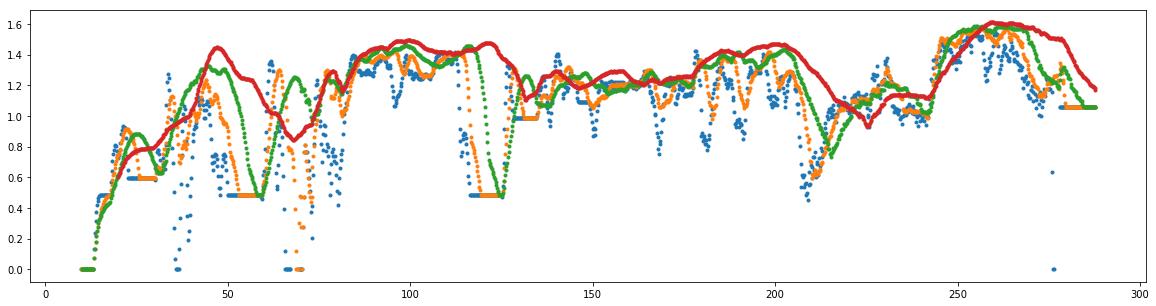

In [28]:
plt.figure(figsize=[20,5])

windows = np.unique(a1.window)
for w in windows[:4]:
    a1_w = a1.loc[a1.window==w]
    #plt.plot(a1_w['time'], a1_w['max_dist'], '.')
    plt.plot(a1_w['time'], a1_w['avg_dist'], '.')

In [44]:
%load ./tonal_spiral.py

c = get_xyz(0)
int_distances = {}
for i in range(7):
    int_distances[i] = scipy.spatial.distance.euclidean(c, get_xyz_note(i))

# Play

In [26]:
def print_pitch_set(pitch_set, txt_file=None):
    output = ""
    for pitch in pitch_set:
        output += pitch + " "
    print(output, file=txt_file)
    return
    
# Input: pitch class data frame
# Output: text file with note names (per Dorien Herremen's audio visualizer)
def pc_to_text(pc, pc_dict, outfile_name):
    f = open(outfile_name, 'w')
    pc = pc.iloc[::10] # 2 second increments
    for i in range(len(pc)):
        pitch_set = []
        for note in range(12):
            num_reps = int(np.nan_to_num(pc.iloc[i][note]))
            for n in range(num_reps):
                pitch_set.append(pc_dict[note])
        print_pitch_set(pitch_set, f)
        
    f.close()
    return

In [2]:
summary_combined = pd.read_csv("../summary-combined.csv")

In [4]:
coupled = summary_combined.loc[summary_combined.condition=="coupled"]

In [64]:
coupled.iloc[5].yolked_id

5

In [65]:
def get_yolked_id(name_):
    p1 = re.search('([a-z]*[0-9])([a-z]*[0-9])',name_).group(1)
    p2 = re.search('([a-z]*[0-9])([a-z]*[0-9])',name_).group(2)
    for i in range(len(coupled)):
        coupled_name = coupled.iloc[i]['name']
        coupled_p1 = re.search('([a-z]*[0-9])([a-z]*[0-9])',coupled_name).group(1)
        coupled_p2 = re.search('([a-z]*[0-9])([a-z]*[0-9])',coupled_name).group(2)
        if (p1==coupled_p1)|(p1==coupled_p2)|(p2==coupled_p1)|(p2==coupled_p2):
            # we have a match
            return coupled.iloc[i]['yolked_id']
    print("error")
    return None

# Functions

In [35]:
a1_pc = pd.read_csv(glob(PC_DIR_IND+"*")[0])
b1_pc = pd.read_csv(glob(PC_DIR_IND+"*")[1])
#a1_int = pd.read_csv(glob(INT_DIR+"*")[0])

In [36]:
def is_empty_pc_hist(pc_hist):
	pc_hist = np.nan_to_num(pc_hist)
	for i in range(len(pc_hist)):
		if pc_hist[i] > 0: return False
	return True

def get_interval(pitch1, pitch2):
    interval = abs(pitch1-pitch2)
    if interval > 6:
        interval = 6-(interval-6)
    return interval

def pitch_to_interval_hist(pitch_histogram):
	intervals = [0]*7
	# count intervals
	for i in range(12):
		for j in range(i, 12):
			interval = get_interval(i, j)
			intervals[interval] += pitch_histogram[i]*pitch_histogram[j] # ToDo: is this the right way to go?
	return intervals

#########################################################
# Input: two pitch class histograms, tonal topology map
# Output: scalar distance between two pitch clouds
#########################################################
def between_cloud_distance(pc_hist1, pc_hist2, topology):
	if (is_empty_pc_hist(pc_hist1) | is_empty_pc_hist(pc_hist2)): return None

	# get inner cloud distances
	ic_hist1 = pitch_to_interval_hist(pc_hist1)
	ic_hist2 = pitch_to_interval_hist(pc_hist2)
	inner_dist1 = ic_hist_to_distance(ic_hist1, topology)
	inner_dist2 = ic_hist_to_distance(ic_hist2, topology)
	
	# get inter cloud distance
	ic_hist_combined = [0]*7
	for pc1 in range(12):
		for pc2 in range(pc1, 12):
			ic = get_ic(pc1, pc2)
			ic_freq = ic_hist1[pc1]*ic_hist2[pc2]
			ic_hist_combined[ic] += ic*ic_freq
	inter_dist = ic_hist_to_distance(ic_hist_combined, topology)

	distance = inter_dist/min(inner_dist1, inner_dist2)  # ToDo: is this the best formalization?
	return distance